In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import os
import matplotlib.pyplot as plt
import inspect
import json

import re
from tqdm import tqdm
from konlpy.tag import Okt

inspect.getfile(plt)

2023-11-26 19:34:44.401703: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-26 19:34:45.881836: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


'/home/nbumkim/anaconda3/envs/yolov7/lib/python3.9/site-packages/matplotlib/pyplot.py'

In [2]:
tf.__version__

'2.13.0'

In [2]:
# gpu driver 확인
gpu = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(gpu[0], enable=True)
print(gpu)

IndexError: list index out of range

## 모델에 필요한 값 선언

In [4]:
## Data 경로 설정
DATA_IN_PATH = './data_in/csv_short/'
DATA_OUT_PATH = './data_out/csv_short/'
TRAIN_INPUTS = 'train_inputs.npy'
TRAIN_OUTPUTS = 'train_outputs.npy'
TRAIN_TARGETS = 'train_targets.npy'
DATA_CONFIGS = 'data_configs.json'

## 파일 일기
index_inputs = np.load(open(DATA_IN_PATH + TRAIN_INPUTS, 'rb'))
index_outputs = np.load(open(DATA_IN_PATH + TRAIN_OUTPUTS , 'rb'))
index_targets = np.load(open(DATA_IN_PATH + TRAIN_TARGETS , 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

In [124]:
index_inputs

array([[ 53,  82,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 53,  15,  82,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [100,  93,  45,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 60,  33,  91,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [110,  52,  78,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 34,  77,  68,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 10,  37,  74,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
      

In [125]:
## Random seed 설정
# SEED_NUM = 1234
# tf.random.set_seed(SEED_NUM)

## 모델 변수값
MODEL_NAME = 'seq2seq_kor_Attention'
BATCH_SIZE = 2
MAX_SEQUENCE = 25
EPOCH = 30
UNITS = 1024
EMBEDDING_DIM = 256
VALIDATION_SPLIT = 0.1 

char2idx = prepro_configs['char2idx']
idx2char = prepro_configs['idx2char']
std_index = prepro_configs['std_symbol']
end_index = prepro_configs['end_symbol']
vocab_size = prepro_configs['vocab_size'] # ['<PAD>\n', '<SOS>\n', '<END>\n', ... ,

print(char2idx) # {'<PAD>': 0, '<SOS>': 1, '<END>': 2, '<UNK>': 3,
print(idx2char) # {'0': '<PAD>', '1': '<SOS>', '2': '<END>', '3': '<UNK>', '4': '혼자인게', '5':  숫자 결과를 문장으로 변환할 때
print(std_index) # <SOS>
print(end_index) # <END>
print('vocab_size: ', vocab_size) # 111

{'<PAD>': 0, '<SOS>': 1, '<END>': 2, '<UNK>': 3, '구하셨나요': 4, '어서': 5, '평소에': 6, '바빠': 7, '잘생겼어': 8, '돌아가서': 9, '가스불': 10, '게': 11, '더': 12, '결단은': 13, '운동만': 14, '뭐하는지': 15, '마세요': 16, '좀': 17, '같아': 18, '나오세요': 19, '같아요': 20, '안': 21, '혼자를': 22, '나': 23, '적당히': 24, '다시': 25, '필요한': 26, '따뜻하게': 27, '너무': 28, '하세요': 29, '거예요': 30, '전생에': 31, '필요했던': 32, '자의': 33, '가상화폐': 34, '생각해보세요': 35, '켜놓고': 36, '켜고': 37, '따라': 38, '생일인데': 39, '집착하지': 40, '집에': 41, '데려가고': 42, '또': 43, '좋아요': 44, '좋다': 45, '달에는': 46, '즐기세요': 47, '열': 48, '끄고': 49, '식혀주세요': 50, '마음을': 51, '있어도': 52, '가끔': 53, '많이': 54, '때까지': 55, '훈훈해': 56, '오늘': 57, '그럴': 58, '뭘': 59, '가난한': 60, '운동을': 61, '돈은': 62, '좋을까': 63, '들어올': 64, '사세요': 65, '사람도': 66, '질린다': 67, '망함': 68, '선물로': 69, '뭐가': 70, '나온거': 71, '그': 72, '것': 73, '나갔어': 74, '거짓말': 75, '감기': 76, '쫄딱': 77, '땀난다': 78, '좋을': 79, '설득해보세요': 80, '싶어': 81, '궁금해': 82, '승진': 83, '보인다': 84, '믿어줘': 85, '땀을': 86, '다음': 87, '갔어': 88, '걸리겠어': 89, '줄까': 90, '설움': 91, '잊고': 92, '혼자인게

# seq2seq 모델
## Encoder

In [126]:
class Encoder(keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz # 2
        self.enc_units = enc_units # 1024
        self.vocab_size = vocab_size # 111
        self.embedding_dim = embedding_dim # 256
        self.embedding = keras.layers.Embedding(self.vocab_size, self.embedding_dim)
        self.gru = keras.layers.GRU(self.enc_units,
                                    return_sequences=True,
                                    return_state=True,
                                    recurrent_initializer='glorot_uniform')
        
    def call(self, x, hidden):
        x = self.embedding(x) # x shape = (20, 25)
        # x shape = (20, 25, 256)
        
        # w/o attention
        # _, state = self.gru(x, initial_state=hidden)

        # w attention
        output, state = self.gru(x, initial_state=hidden)        
        return output, state 
        # output = (20, 25, 1024), state shape = (20, 1024)
    
    def initialize_hidden_state(self, inp):
        return tf.zeros((tf.shape(inp)[0], self.enc_units)) # inp shape = [20, 25], self.enc_units = 1024

In [127]:
# ################################# Code testing

# train_X = [[[0.1, 4.2, 1.5, 1.1, 2.8], 
#            [1.0, 3.1, 2.5, 0.7, 1.1], 
#            [0.3, 2.1, 1.5, 2.1, 0.1], 
#            [2.2, 1.4, 0.5, 0.9, 1.1]],

#            [[0.1, 4.2, 1.5, 1.1, 2.8], 
#            [1.0, 3.1, 2.5, 0.7, 1.1], 
#            [0.3, 2.1, 1.5, 2.1, 0.1], 
#            [2.2, 1.4, 0.5, 0.9, 1.1]]]
# train_X = tf.convert_to_tensor(train_X, dtype=tf.float32)
# print(tf.shape(train_X))

# gru =  tf.keras.layers.GRU(units = 3, 
#                            return_sequences=True, 
#                            return_state=True)
# a, b = gru(train_X)
# print(a) # encoder time-step
# print(b)

In [128]:
## Encoder check
# enc_hidden_init = tf.random.normal((20, 1024))
# # vocab_size = 111, EMBEDDING_DIM = 256, UNITS = 1024, BATCH_SIZE = 2
# encoder = Encoder(vocab_size, EMBEDDING_DIM, UNITS, BATCH_SIZE) 
# enc_hidden = encoder(index_inputs, enc_hidden_init )
# enc_hidden.shape

## Bahdanu's Attention

In [129]:
# a = tf.random.normal((2,4))  # (batch_size, hidden size)
# print(a)
# print("="*50)
# b = tf.expand_dims(a, 1)
# print(b)

In [130]:
## check tensor sum
# cx = tf.constant([[1,1,1,1],
#                   [2, 2, 2, 2]], dtype=tf.float32)
# print(cx)

####################################################
# cx = tf.constant([[[1,1,1,1]],
#                   [[2, 2, 2, 2]]], dtype=tf.float32)
# print(cx)

# cy = tf.zeros((2, 2, 4))
# print(cy)

# cxy = cx + cy
# print(cxy)

####################################################
# cd = tf.random.normal((2, 3, 1), dtype = tf.float32)
# print(cd)

# tf.nn.softmax(cd, axis = 1)

In [131]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units): # units = 1024
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units) # decoder units
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values): # query: hidden from dec, values: enc_output
        # 스코어(score)계산을 위해 덧셈을 수행하고자 시간 축을 확장하여 아래의 과정을 수행합니다.
        query_with_time_axis = tf.expand_dims(query, 1) 
        # query_with_time_axis = (batch_size, 1, hidden size)
        # values = (batch_size, max_len, hidden size)
        
        # score는 (batch_size, max_length, 1)쌍으로 이루어져 있습니다.
        # score를 self.V에 적용하기 때문에 마지막 축에 1을 얻습니다.
        # self.V에 적용하기 전에 텐서는 (batch_size, max_length, units)쌍으로 이루어져 있습니다.
        score = self.V(tf.nn.tanh(
            self.W1(values) + self.W2(query_with_time_axis)))

        attention_weights = tf.nn.softmax(score, axis=1)

        context_vector = attention_weights * values # weighted sum of values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

## Decoder

In [132]:
class Decoder(keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim

        self.embedding = keras.layers.Embedding(self.vocab_size, self.embedding_dim)
        self.gru = keras.layers.GRU(self.dec_units,
                                    return_sequences=True,
                                    return_state=True,
                                    recurrent_initializer='glorot_uniform')
        self.fc = keras.layers.Dense(self.vocab_size)
        
        # w attention
        self.attention = BahdanauAttention(self.dec_units)
        
    def call(self, x, hidden, enc_output):
        # hidden = query, enc_output = values
        context_vector, attention_weights = self.attention(hidden, enc_output)
        
        x = self.embedding(x) #  x dec_input = tf.dtypes.cast(tf.expand_dims(tar[:, t], 1), tf.float32) shape =  (20, 1)
        # x shape = (20, 1, 256)
        
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        # x shape = (batch_size, 1, embedding + context_vector)
        
        output, state = self.gru(x) # state = dec_hidden
        # output shape = (20, 1, 1024), state shape = (20, 1024)
        output = tf.reshape(output, (-1, output.shape[2]))

        x = self.fc(output)
        # x shape = (20, 111)
        
        return x, state, attention_weights

In [133]:
# decoder check
# dec_input = tf.dtypes.cast(tf.expand_dims(index_outputs[:, 0], 1), tf.float32)
# dec_hidden =  enc_hidden
# # print(dec_input.shape) # (20, 1)

# decoder = Decoder(vocab_size, EMBEDDING_DIM, UNITS, BATCH_SIZE)
# x, stats, output = decoder(dec_input, dec_hidden)
# print('x =', x.shape)
# print('stats =', stats.shape)
# print('output =', output.shape)

## Loss Function

In [134]:
# optimizer = tf.keras.optimizers.Adam()
loss_object = keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction ='none')
train_accuracy = keras.metrics.SparseCategoricalAccuracy(name='accuracy')
###########
# real = [1, 3]
# pred = [[0.05, 0.9, 0, 0.05], 
#           [0.1, 0.8, 0.05, 0.05]]
###########

def loss(real, pred): # real shape = (20, 25), pred shape = (20, 25, 111)
    mask = tf.math.logical_not(tf.math.equal(real, 0)) # real 값이 0 이면 True => tf.math.logical_not => False
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

###########################################
# real = tf.convert_to_tensor([[2, 1, 0], 
#                              [1, 0, 0]])
# pred = tf.convert_to_tensor([[[0.1, 0.6, 0.3], [0.05, 0.95, 0], [0.1, 0.6, 0.3]],
#                              [[0.1, 0.6, 0.3], [0.05, 0.95, 0], [0.1, 0.6, 0.3]]])
###########################################

# real shape = (20, 25)
# pred shape = (20, 25, 111)
# def accuracy(real, pred):
#     mask = tf.math.logical_not(tf.math.equal(real, 0))
#     mask = tf.expand_dims(tf.cast(mask, dtype = pred.dtype), axis = -1) # mask tf.Tensor: shape=(20, 25)
#     # mask tf.Tensor: shape=(20, 25, 1)
#     pred *= mask
#     acc = train_accuracy(real, pred)
#     return tf.reduce_mean(acc)

In [135]:
## check loss

# loss_object = keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction ='none')
# real = tf.convert_to_tensor([[2, 1, 0], 
#                              [1, 0, 0]])
# pred = tf.convert_to_tensor([[[0.1, 0.6, 0.3], [0.05, 0.95, 0], [0.1, 0.6, 0.3]],
#                              [[0.1, 0.6, 0.3], [0.05, 0.95, 0], [0.1, 0.6, 0.3]]])


# mask = tf.math.logical_not(tf.math.equal(real, 0)) # real 값이 0 이면 True => tf.math.logical_not => False
# print(mask)
# loss = loss_object(real, pred)
# print(loss)
# mask = tf.cast(mask, dtype=loss.dtype)
# loss *= mask
# print("loss *= mask", loss)
# tf.reduce_mean(loss)

## seq2seq 모델

In [136]:
# MODEL_NAME = 'seq2seq_kor'
# BATCH_SIZE = 2
# MAX_SEQUENCE = 25
# EPOCH = 30
# UNITS = 1024
# EMBEDDING_DIM = 256
# VALIDATION_SPLIT = 0.1
# vocab_size = 111 # ['<PAD>\n', '<SOS>\n', '<END>\n', ... 
# history = model.fit([index_inputs, index_outputs], index_targets,
#                     batch_size=BATCH_SIZE, epochs=EPOCH,
#                     validation_split=VALIDATION_SPLIT, callbacks=[earlystop_callback, cp_callback])

class seq2seq(keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, dec_units, 
                 batch_sz, end_token_idx = 2):
        super(seq2seq, self).__init__()
        self.end_token_idx = end_token_idx
        self.encoder = Encoder(vocab_size, embedding_dim, enc_units, batch_sz)
        self.decoder = Decoder(vocab_size, embedding_dim, dec_units, batch_sz)
        
    def call(self, x):
        inp, tar = x # [index_inputs, index_outputs]
        
        end_hidden = self.encoder.initialize_hidden_state(inp) # 20 x 25 (sentence x MAX_SEQUENCE)
        # end_hidden =  zeros (20, 1024 (enc_units)) 
        enc_output, enc_hidden = self.encoder(inp, end_hidden)  # enc_state (20, 1024) only last(hidden) state
        dec_hidden = enc_hidden

        predict_tokens = list()
        for t in range(0, tar.shape[1]): # tar.shape = (20, 25 (MAX_LENGTH))
            dec_input = tf.dtypes.cast(tf.expand_dims(tar[:, t], 1), tf.float32) # tar[:, t].shape = (20,  )
            # dec_input shape = (20, 1)
            predictions, dec_hidden, _ = self.decoder(dec_input, dec_hidden, enc_output)
            # predictions shape = (20, 111), dec_hidden = (20, 1024)
            predict_tokens.append(tf.dtypes.cast(predictions, tf.float32))
            # predict_tokens shape = (25, 20, 111)

        predicted = tf.stack(predict_tokens, axis=1) #   
        return predicted # tf.Tensor: shape=(20, 25, 111)
        
    def inference(self, x):
        inp = x
       
        enc_hidden = self.encoder.initialize_hidden_state(inp)
        # enc_hidden_init size = (, 1024)
        enc_output, enc_hidden = self.encoder(inp, enc_hidden)

        dec_hidden = enc_hidden
        dec_input = tf.expand_dims([char2idx[std_index]], 1)
        
        predict_tokens =  list()
        for t in range(0, MAX_SEQUENCE):
            predictions, dec_hidden, _ = self.decoder(dec_input, dec_hidden, enc_output)
            predict_token = tf.argmax(predictions[0]) # predictions shape =  (1, 111)
            
            if predict_token == self.end_token_idx:
                break

            predict_tokens.append(predict_token)
            dec_input = tf.dtypes.cast(tf.expand_dims([predict_token], 0), tf.float32)
            
        return tf.stack(predict_tokens, axis=0).numpy()
        

In [137]:
# decoder check
# x_tokens = list()
# for i in range(2):
#     dec_input = tf.dtypes.cast(tf.expand_dims(index_outputs[:, i], 1), tf.float32)
#     dec_hidden =  enc_hidden
#     # print(dec_input.shape) # (20, 1)

#     decoder = Decoder(vocab_size, EMBEDDING_DIM, UNITS, BATCH_SIZE)
#     x, stats, output = decoder(dec_input, dec_hidden)
#     x_tokens.append(tf.dtypes.cast(x, tf.float32))

# print('x =', x.shape)
# print('x_tokens =', tf.convert_to_tensor(x_tokens).shape)
# print('stats =', stats.shape)
# print('output =', output.shape)
# predicted = tf.stack(x_tokens, axis=1)
# predicted.shape

In [138]:
model = seq2seq(vocab_size, EMBEDDING_DIM, UNITS, UNITS, BATCH_SIZE, char2idx[end_index])
model.compile(loss = loss, optimizer=keras.optimizers.Adam(1e-3))

In [139]:
PATH = DATA_OUT_PATH + MODEL_NAME
if not(os.path.isdir(PATH)):
        os.makedirs(os.path.join(PATH))
        
checkpoint_path = DATA_OUT_PATH + MODEL_NAME + '/weights.h5'

cp_callback = keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
earlystop_callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10)
history = model.fit([index_inputs, index_outputs], index_targets,
                    batch_size=BATCH_SIZE, epochs=EPOCH,
                    validation_split=VALIDATION_SPLIT, 
                    callbacks=[earlystop_callback, cp_callback])

Epoch 1/30


9/9 [==============================] - ETA: 0s - loss: 0.8200
Epoch 1: val_loss improved from inf to 0.63516, saving model to ./data_out/seq2seq_kor/weights.h5
9/9 [==============================] - 35s 986ms/step - loss: 0.8200 - val_loss: 0.6352
Epoch 2/30
9/9 [==============================] - ETA: 0s - loss: 0.7292
Epoch 2: val_loss improved from 0.63516 to 0.62884, saving model to ./data_out/seq2seq_kor/weights.h5
9/9 [==============================] - 1s 117ms/step - loss: 0.7292 - val_loss: 0.6288
Epoch 3/30
9/9 [==============================] - ETA: 0s - loss: 0.6626
Epoch 3: val_loss improved from 0.62884 to 0.56961, saving model to ./data_out/seq2seq_kor/weights.h5
9/9 [==============================] - 1s 116ms/step - loss: 0.6626 - val_loss: 0.5696
Epoch 4/30
9/9 [==============================] - ETA: 0s - loss: 0.6166
Epoch 4: val_loss improved from 0.56961 to 0.55416, saving model to ./data_out/seq2seq_kor/weights.h5
9/9 [==============================] - 1s 119ms/step 

In [140]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+ string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.ylim(0, 1)
    plt.legend([string, 'val_'+string])
    plt.show()

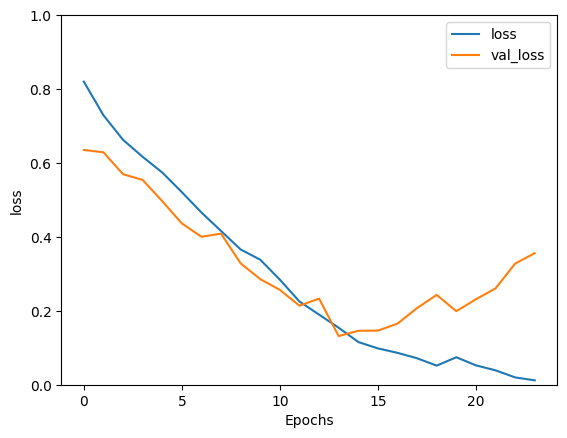

In [141]:
plot_graphs(history, 'loss')

## 결과 확인

In [142]:
SAVE_FILE_NM = "weights.h5"
model.load_weights(os.path.join(DATA_OUT_PATH, MODEL_NAME, SAVE_FILE_NM))

In [143]:
FILTERS = "([~.,!?\"':;)(])"
CHANGE_FILTER = re.compile(FILTERS)


PAD = "<PAD>"
STD = "<SOS>"
END = "<END>"
UNK = "<UNK>"


def prepro_like_morphlized(data):
    morph_analyzer = Okt()
    result_data = list()
    for seq in tqdm(data):
        morphlized_seq = " ".join(morph_analyzer.morphs(seq.replace(' ', '')))
        result_data.append(morphlized_seq)

    return result_data

def enc_processing(value, dictionary, tokenize_as_morph=False):
    sequences_input_index = []
    sequences_length = []

    if tokenize_as_morph:
        value = prepro_like_morphlized(value)

    for sequence in value:
        sequence = re.sub(CHANGE_FILTER, "", sequence)

        sequence_index = []
        for word in sequence.split():
            if dictionary.get(word) is not None:
                sequence_index.extend([dictionary[word]])
            else:
                sequence_index.extend([dictionary[UNK]])

        if len(sequence_index) > MAX_SEQUENCE:
            sequence_index = sequence_index[:MAX_SEQUENCE]

        sequences_length.append(len(sequence_index))
        sequence_index += (MAX_SEQUENCE - len(sequence_index)) * [dictionary[PAD]]
        sequences_input_index.append(sequence_index)

    return np.asarray(sequences_input_index), sequences_length

In [151]:
# query = "남자친구가 나 안 믿어줘"

query = "남자친구 교회 데려가고 싶어"


test_index_inputs, _ = enc_processing([query], char2idx) 
print(test_index_inputs)

predict_tokens = model.inference(test_index_inputs)
print(predict_tokens)

print(' '.join([idx2char[str(t)] for t in predict_tokens]))

[[96 98 42 81  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]]
[ 6 26 73 35]
평소에 필요한 것 생각해보세요
